In [1]:
import ROOT
import numpy as np
import uproot
from ROOT import TGraphErrors
from ROOT import TVectorT
import matplotlib.pyplot as plt
from matplotlib import ticker

Welcome to JupyROOT 6.22/06


## File and N_Missing Cut

In [2]:
No_Missing_Const = False
latex_dir="/Users/fernando/Documents/silliconcombined/figs/"
#latex_dir="./"
#filename = "../../output/Missing_const_output_mom_res_combined_electrons+jetssigma_eta_5_p_5_.root"
filename = "../../output/Missing_const_output_mom_res_combined_electrons+jetssigma_eta_5_p_6_.root"
if No_Missing_Const:
    #filename = "../../output/No_Missing_const_output_mom_res_combined_electrons+jetssigma_eta_5_p_5_.root"
    filename = "../../output/No_Missing_const_output_mom_res_combined_electrons+jetssigma_eta_5_p_6_.root"

file = ROOT.TFile(filename)
prefixes = ["dpp","dth","dph"]

descr = filename.split("+")[1].split(".")[0]
if (No_Missing_Const):
    fig_name = "No_Missing_Const_"+descr+"plots.pdf"
else:
    fig_name = "Missing_Const_"+descr+"plots.pdf"

## Binning

In [3]:
def TVT_to_numpy(file,TVectorT_name):
    TVectorT = file.Get(TVectorT_name)
    N = TVectorT.GetNoElements()
    np_bins = np.zeros(N)
    for i in range(N):
        np_bins[i] = TVectorT[i]
    return np_bins,N-1 #return number of bin centers

eta_bins, N_eta = TVT_to_numpy(file,"TVT_eta_bin")
eta_centers = (eta_bins[1:] + eta_bins[:-1]) /2
eta_widths = [(j-i)/2 for i, j in zip(eta_bins[:-1], eta_bins[1:])]

mom_bins, N_mom = TVT_to_numpy(file,"TVT_mom_bin")
mom_centers = (mom_bins[1:] + mom_bins[:-1]) /2
mom_widths = [(j-i)/2 for i, j in zip(mom_bins[:-1], mom_bins[1:])]

## TH1 -> Dictionary

In [4]:
def TH1_to_numpy_wErrors(file, TH1_name):    
    th1 = file.Get(TH1_name)
    N = th1.GetNbinsX()
    th1_array = np.zeros(N)
    th1_errors = np.zeros(N)
    
    for i in range(N):
        val = th1.GetBinContent(i+1)
        error = th1.GetBinError(i+1)
        if val == 0: #ROOT for some reason puts unconverged fits from poor stats to 0. Should be NaN
            val = np.nan
        if error/val >= 0.5: 
            val=np.nan #skip converged fits with poor statistics
        th1_array[i] = val
        th1_errors[i] = error
    
    return th1_array, th1_errors

In [5]:
eta_dict = {}
for s in prefixes:
    for eta_v_p in range(N_eta):  #there is a distribution as a function of momentum for each eta bin  
        eta_dict["eta_%s_%i"%(s,eta_v_p)],eta_dict["eta_%s_%i_Errors"%(s,eta_v_p)] = TH1_to_numpy_wErrors(file,"h1_%s_v_p_et_bins_%i"%(s,eta_v_p))

mom_dict = {}
for s in prefixes:
    for p_v_eta in range(N_mom):    
        mom_dict["p_%s_%i"%(s,p_v_eta)],mom_dict["p_%s_%i_Errors"%(s,p_v_eta)] = TH1_to_numpy_wErrors(file,"h1_%s_v_et_p_bins_%i"%(s,p_v_eta))

### mrad conversion

In [6]:
do_conversion = False
if do_conversion:
    rad_mrad = 1000
    for s in prefixes:
        if (s!="dpp"):
            for eta_v_p in range(N_eta):
                eta_dict["eta_%s_%i"%(s,eta_v_p)]=eta_dict["eta_%s_%i"%(s,eta_v_p)]*rad_mrad
                eta_dict["eta_%s_%i_Errors"%(s,eta_v_p)] = eta_dict["eta_%s_%i_Errors"%(s,eta_v_p)]*rad_mrad
            for p_v_eta in range(N_mom):    
                mom_dict["p_%s_%i"%(s,p_v_eta)] = mom_dict["p_%s_%i"%(s,p_v_eta)]*rad_mrad
                mom_dict["p_%s_%i_Errors"%(s,p_v_eta)] = mom_dict["p_%s_%i_Errors"%(s,p_v_eta)]*rad_mrad

## Colors

In [7]:
def get_colors(color_map, N):
    evenly_spaced_interval = np.linspace(0, 1, N)
    colors = [color_map(x) for x in evenly_spaced_interval]
    return colors

eta_colors = get_colors(plt.cm.winter, N_eta)
mom_colors = get_colors(plt.cm.autumn,N_mom)


test = False
if test:
    x = np.linspace(0, 10, 100)
    lines = [np.sin(x), np.cos(x), np.sin(x + 2), np.cos(x+2), np.sin(x +4)]
    for i, color in enumerate(mom_colors):
        plt.plot(lines[i], color = color)

## Min/Max for Y-axis (overlays)

In [10]:
max_scale = 1.3
min_scale = 0.001
ranges = {}
for s in prefixes:
    min = 999.
    max = 0.
    for eta in range(N_eta):
        temp_min = np.nanmin(eta_dict["eta_%s_%i"%(s,eta)] - eta_dict["eta_%s_%i_Errors"%(s,eta)])
        if (temp_min < min):
            min = temp_min
        
        temp_max = np.nanmax(eta_dict["eta_%s_%i"%(s,eta)] + eta_dict["eta_%s_%i_Errors"%(s,eta)])
        if (temp_max > max):
            max = temp_max
          
    ranges["eta_%s_min"%(s)] = min*min_scale
    ranges["eta_%s_max"%(s)] = max*max_scale
    
    for p in range(N_mom):
        temp_min = np.nanmin(mom_dict["p_%s_%i"%(s,p)] - mom_dict["p_%s_%i_Errors"%(s,p)])
        if (temp_min < min):
            min = temp_min
        
        temp_max = np.nanmax(mom_dict["p_%s_%i"%(s,p)] + mom_dict["p_%s_%i_Errors"%(s,p)])
        if (temp_max > max):
            max = temp_max
          
    ranges["mom_%s_min"%(s)] = min*min_scale
    ranges["mom_%s_max"%(s)] = max*max_scale

print(ranges)

{'eta_dpp_min': 0.01337796888872981, 'eta_dpp_max': 24.111797034461052, 'mom_dpp_min': 0.01337796888872981, 'mom_dpp_max': 24.111797034461052, 'eta_dth_min': 0.014020063996315002, 'eta_dth_max': 46.70543123483658, 'mom_dth_min': 0.014020063996315002, 'mom_dth_max': 46.70543123483658, 'eta_dph_min': 0.020062128305435183, 'eta_dph_max': 64.87868537902833, 'mom_dph_min': 0.020062128305435183, 'mom_dph_max': 64.87868537902833}


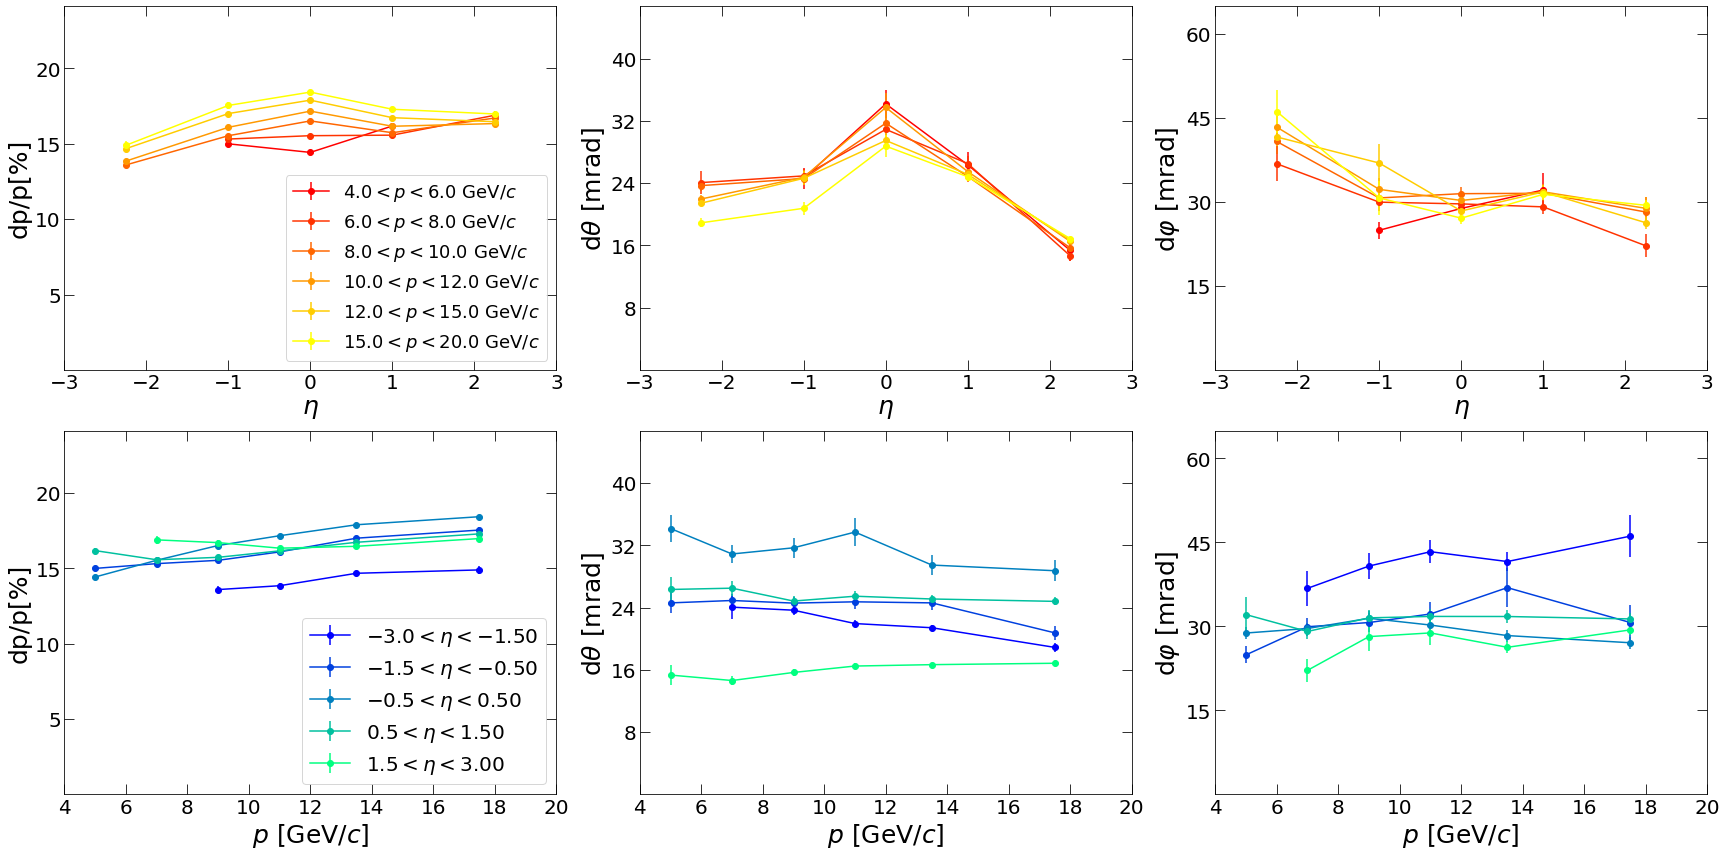

In [13]:
fig = plt.figure(figsize=(24,12))

N_divs = (int(len(mom_dict)/N_mom)) #1/2 factor from Errors in dict, 2 factor from eta panels
ylabels = ["dp/p[%]",r"d$\theta$ [mrad]",r"d$\varphi$ [mrad]"]
fmt = "o-"
tick_leg_size = 20
label_size = 25
for i in range(N_divs):
    s = i%len(prefixes) #for dpp,dth,dph switching
        
    #aesthetics
    plt.tight_layout()
    ax = fig.add_subplot(2,int(N_divs/2),i+1)
        
    if (i < N_divs/2):
        for p in range(N_mom):
            plt.errorbar(eta_centers,mom_dict["p_%s_%i"%(prefixes[s],p)],yerr=mom_dict["p_%s_%i_Errors"%(prefixes[s],p)],
                         fmt=fmt,color = mom_colors[p],label="$%1.1f<p<%1.1f~\mathrm{GeV}/c$"%(mom_bins[p],mom_bins[p+1]))
        plt.xlabel(r'$\eta$',fontsize=25,x=0.5)
        plt.ylim(ranges["mom_%s_min"%(prefixes[s])],ranges["mom_%s_max"%(prefixes[s])])           
        plt.xlim(np.min(eta_bins),np.max(eta_bins))
        
    else:
        for eta in range(N_eta):
            plt.errorbar(mom_centers,eta_dict["eta_%s_%i"%(prefixes[s],eta)],yerr=eta_dict["eta_%s_%i_Errors"%(prefixes[s],eta)],
                         fmt=fmt,color = eta_colors[eta],label="$%1.1f<\eta<%1.2f$"%(eta_bins[eta],eta_bins[eta+1]))#confusing...
            plt.xlabel(r'$p~\mathrm{[GeV}/c]$',fontsize=25,x=0.5)
        plt.ylim(ranges["eta_%s_min"%(prefixes[s])],ranges["eta_%s_max"%(prefixes[s])])
        plt.xlim(np.min(mom_bins),np.max(mom_bins))
        
    #Legend Placement
    if(No_Missing_Const):
        if (i==2): plt.legend(fontsize=tick_leg_size-2,loc='upper center')
        if (i==4): plt.legend(fontsize=tick_leg_size)
    else:
        if (i==0): plt.legend(fontsize=tick_leg_size-2,loc='lower right')
        if (i==3): plt.legend(fontsize=tick_leg_size,loc='lower right')
        
    plt.tick_params(which='both',direction='in',right=True,top=True,bottom=True,length=10,labelsize=20)
    #plt.yscale("log")
    #ax.ticklabel_format(style='plain')
    yticks = ticker.MaxNLocator(6)
    plt.ylabel(ylabels[s],fontsize=label_size,y=0.5)
    ax.yaxis.set_major_locator(yticks)

plt.savefig(latex_dir+fig_name)